In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mnist_reader
from sklearn.decomposition import PCA


# === 1. 資料準備 ===

x_train, y_train = mnist_reader.load_data('../dim_reduction/data/oracle', kind='train')
x_test, y_test = mnist_reader.load_data('../dim_reduction/data/oracle', kind='t10k')

x_train = x_train.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(x_test), torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# === 2. CNN 模型定義 ===

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x, return_features=False):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        features = F.relu(self.fc1(x))
        if return_features:
            return features
        return self.fc2(features)

# 1. 載入訓練好的模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=10).to(device)
# model.load_state_dict(torch.load("best_cnn_model.pt"))
model.load_state_dict(torch.load("best_cnn_model.pt", map_location=torch.device("cpu")))
model.eval()

# 2. 特徵提取函數
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            feats = model(images, return_features=True)  # 使用 return_features=True
            features.append(feats.cpu().numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

# 3. 執行特徵擷取（可選擇 train 或 test）
X_train_feats, y_train = extract_features(model, train_loader)
X_test_feats, y_test = extract_features(model, test_loader)

# 4. 儲存
# os.makedirs("cnn_features", exist_ok=True)
# np.save("cnn_features/cnn_train_features.npy", X_train_feats)
# np.save("cnn_features/cnn_train_labels.npy", y_train)
# np.save("cnn_features/cnn_test_features.npy", X_test_feats)
# np.save("cnn_features/cnn_test_labels.npy", y_test)

components_list = [2, 4, 8, 16, 32]
pca_results = {}

for n_components in components_list:    
    # 執行 PCA
    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(X_train_feats)
    x_test_pca = pca.transform(X_test_feats)

    # 儲存 PCA 結果
    pca_results[n_components] = {
        "pca_model": pca,
        "x_train_pca": x_train_pca,
        "x_test_pca": x_test_pca,
    }


The size of train set: 27222
The size of t10k set: 3000


C:\Users\ted12\AppData\Local\Temp\ipykernel_10056\684078754.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_cnn_model.pt", map_lo

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# PCA + K-mean clustering

cluster_results = {}  # 用來儲存分群結果與 ARI 指標

for n_components, data in pca_results.items():
    x_pca = data["x_train_pca"]

    # 使用 KMeans 做 clustering，K=10 模擬 10 個數字類別
    kmeans = KMeans(n_clusters=10, random_state=42)
    cluster_labels = kmeans.fit_predict(x_pca)

    # 計算 clustering 效果
    ari = adjusted_rand_score(y_train, cluster_labels)

    # 儲存結果
    cluster_results[n_components] = {
        "kmeans_model": kmeans,
        "cluster_labels": cluster_labels,
        "ari": ari
    }

    print(f"PCA={n_components}: ARI={ari:.4f}")


PCA=2: ARI=0.2762
PCA=4: ARI=0.3210
PCA=8: ARI=0.4113
PCA=16: ARI=0.4357
PCA=32: ARI=0.4423


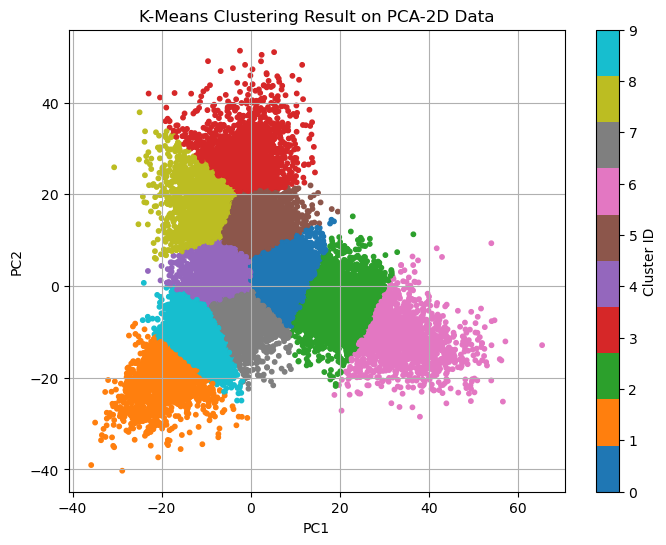

In [6]:
import matplotlib.pyplot as plt

x_pca = pca_results[2]["x_train_pca"]
cluster_labels = cluster_results[2]["cluster_labels"]

plt.figure(figsize=(8, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("K-Means Clustering Result on PCA-2D Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(label="Cluster ID")
# plt.savefig("../results/pca_K-means_output/kmeans_cluster_pca2.png")
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

# PCA + EM clustering

em_cluster_results = {}  # 儲存 EM clustering 結果與 ARI

for n_components, data in pca_results.items():
    x_pca = data["x_train_pca"]

    # 使用 Gaussian Mixture Model (EM)
    gmm = GaussianMixture(n_components=10, random_state=42)
    gmm.fit(x_pca)
    cluster_labels = gmm.predict(x_pca)

    # 計算 clustering 效果
    ari = adjusted_rand_score(y_train, cluster_labels)

    # 儲存結果
    em_cluster_results[n_components] = {
        "gmm_model": gmm,
        "cluster_labels": cluster_labels,
        "ari": ari
    }

    print(f"[GMM] PCA={n_components}: ARI={ari:.4f}")


[GMM] PCA=2: ARI=0.2929
[GMM] PCA=4: ARI=0.4094
[GMM] PCA=8: ARI=0.6145
[GMM] PCA=16: ARI=0.6498
[GMM] PCA=32: ARI=0.5915


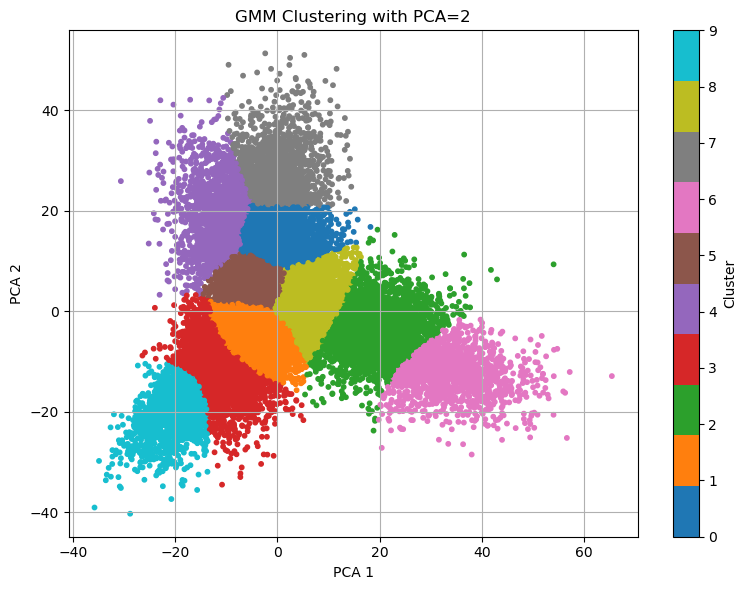

In [4]:
import matplotlib.pyplot as plt

# 選擇要繪製的 PCA 維度數（例如：2 維）
target_pca_dim = 2
x_pca = pca_results[target_pca_dim]["x_train_pca"]
cluster_labels = em_cluster_results[target_pca_dim]["cluster_labels"]

# 畫圖
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title(f'GMM Clustering with PCA={target_pca_dim}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# pca + GNB 

all_reports = []

for n_components in components_list:
    print(f"\n=== PCA({n_components}) + GNB 分類 ===")

    # 取出對應的 PCA 特徵
    x_train_pca = pca_results[n_components]["x_train_pca"]
    x_test_pca = pca_results[n_components]["x_test_pca"]

    # 建立並訓練 GNB 模型
    gnb = GaussianNB()
    gnb.fit(x_train_pca, y_train)

    # 預測與評估
    y_pred = gnb.predict(x_test_pca)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # 儲存報表
    report = classification_report(y_test, y_pred, output_dict=True)
    flat_report = {f"{label}_{metric}": score
                   for label, metrics in report.items() if isinstance(metrics, dict)
                   for metric, score in metrics.items()}
    flat_report["accuracy"] = acc
    flat_report["pca_components"] = n_components
    all_reports.append(flat_report)

# 儲存所有結果成 CSV
df = pd.DataFrame(all_reports)
os.makedirs("../results/CNN/PCA_GNB", exist_ok=True)
df.to_csv("../results/CNN/PCA_GNB/classification_report_all_pca_gnb.csv", index=False)



=== PCA(2) + GNB 分類 ===
Accuracy: 0.5667
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       300
           1       0.82      0.79      0.81       300
           2       0.37      0.49      0.42       300
           3       0.68      0.56      0.62       300
           4       0.40      0.38      0.39       300
           5       0.72      0.77      0.75       300
           6       0.49      0.51      0.50       300
           7       0.42      0.23      0.29       300
           8       0.40      0.49      0.44       300
           9       0.76      0.73      0.74       300

    accuracy                           0.57      3000
   macro avg       0.57      0.57      0.56      3000
weighted avg       0.57      0.57      0.56      3000


=== PCA(4) + GNB 分類 ===
Accuracy: 0.6837
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       300
           1       0.84      0.78      0.81     

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

all_results = []

for n_components in components_list:
    print(f"\n=== PCA({n_components}) + SVM 分類 ===")

    x_train_pca = pca_results[n_components]["x_train_pca"]
    x_test_pca = pca_results[n_components]["x_test_pca"]

    # 建立並訓練 SVM 模型（RBF 核心）
    clf = SVC(kernel='rbf', gamma='scale')
    clf.fit(x_train_pca, y_train)

    # 預測與評估
    y_pred = clf.predict(x_test_pca)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # 混淆矩陣可視化
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix: PCA({n_components}) + SVM")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join("../results/CNN/PCA_SVM", f"cm_pca{n_components}_svm.png"))
    plt.close()

    # 整理 classification report 結果
    report = classification_report(y_test, y_pred, output_dict=True)
    flat_report = {
        f"{label}_{metric}": value
        for label, scores in report.items() if isinstance(scores, dict)
        for metric, value in scores.items()
    }
    flat_report["accuracy"] = acc
    flat_report["pca_components"] = n_components
    all_results.append(flat_report)

# 儲存總表
df = pd.DataFrame(all_results)
df.to_csv(os.path.join("../results/CNN/PCA_SVM", "classification_report_all_pca_svm.csv"), index=False)

# 額外：畫 accuracy vs PCA 維度圖
plt.figure()
plt.plot([r['pca_components'] for r in all_results],
         [r['accuracy'] for r in all_results], marker='o')
plt.title("Accuracy vs PCA Components (CNN feature + SVM)")
plt.xlabel("PCA Components")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join("../results/CNN/PCA_SVM", "accuracy_vs_pca.png"))
plt.close()



=== PCA(2) + SVM 分類 ===
Accuracy: 0.5760
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       300
           1       0.83      0.84      0.83       300
           2       0.36      0.54      0.44       300
           3       0.69      0.59      0.64       300
           4       0.40      0.27      0.32       300
           5       0.76      0.76      0.76       300
           6       0.48      0.57      0.52       300
           7       0.45      0.18      0.26       300
           8       0.39      0.56      0.46       300
           9       0.79      0.73      0.76       300

    accuracy                           0.58      3000
   macro avg       0.59      0.58      0.57      3000
weighted avg       0.59      0.58      0.57      3000


=== PCA(4) + SVM 分類 ===
Accuracy: 0.7547
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       300
           1       0.88      0.88      0.88     